## Importation des librairies

In [479]:
import math
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

## Importation d'une première partie de la Base de données

In [257]:
coordonnees = pd.read_csv("./data/all_accelerometer_data_pids_13.csv",sep=",")

In [258]:
coordonnees = coordonnees[coordonnees.time != 0];

In [259]:
coordonnees.head()

,time,pid,x,y,z
2,1493733882409,SA0297,0.0758,0.0273,-0.0102
3,1493733882455,SA0297,-0.0359,0.0794,0.0037
4,1493733882500,SA0297,-0.2427,-0.0861,-0.0163
5,1493733883945,SA0297,-0.2888,0.0514,-0.0145
6,1493733883953,SA0297,-0.0413,-0.0184,-0.0105


#### Nos seules valeurs sont les coordonnées gyroscopes (x, y, z) du téléphone afin de faire une prédiction sur l'état débriété d'une personne. Ne sachant pas (et ne trouvant pas sur leur papier de recherche) si le référentiel est un référentiel du téléphone (non utilisable car on peut tenir le téléphone de mutliples manière), ou géocentrique, j'ai décidé de transformer ces coordoonées en 3 variables : movement (distance), vitesse et accélération du téléphone avec le minimum, la moyenne et le maximum de chaque aux différents lapse de temps de lecture d'état d'ébriété

### Récupération des PID des participants afin d'importer leurs Base de données

In [260]:
PID = coordonnees.pid.unique()

In [261]:
print(PID)

['SA0297' 'PC6771' 'BK7610' 'DC6359' 'MC7070' 'MJ8002' 'BU4707' 'JR8022'
 'HV0618' 'SF3079' 'JB3156' 'CC6740' 'DK3500']


In [262]:
TAC = {}
for pid_num in PID:
    TAC[pid_num] = pd.read_csv("./data/clean_tac/"+pid_num+"_clean_tac.csv",sep=",")

In [263]:
TAC[PID[3]].head()

,timestamp,TAC_Reading
0,1493719224,-0.002079
1,1493721045,0.000898
2,1493721360,0.002095
3,1493721674,0.001024
4,1493722001,-0.001156


In [264]:
coord = {}
for pid_num in PID:
    coord[pid_num] = coordonnees.loc[coordonnees["pid"] == pid_num]

In [265]:
coord[PID[3]].head()

,time,pid,x,y,z
88314,1493736440950,DC6359,0.0003,-0.0001,0.0038
88317,1493736440969,DC6359,0.0045,-0.0085,-0.0069
88320,1493736441001,DC6359,0.0054,0.0149,0.0135
88323,1493736441023,DC6359,0.0142,0.0195,0.0159
88326,1493736441054,DC6359,0.0439,0.0052,0.0101


#### L'idée ci-dessous est d'abord de rassembler les valeurs des coordonnées entre les lapses de temps de chaque lecture de l'état d'une personne, afin de les traiter par paquet.

In [266]:
bad = 0 #Compteur de mauvaises valeurs/valeurs impossibles
PID_dic = {} #Dictionnaire où seront contenues toutes les informations avant de rassembler les Base de données et de les inclures
for pid_num in PID:    
    previous_time = 0
    
    liste_infos = []
    for row_TAC in TAC[pid_num].itertuples(index=False): #Chaque lecture de l'état (date)
        readings = coord[pid_num].loc[coord[pid_num]["time"].between(previous_time, row_TAC.timestamp*1000)] #Vérification que celle-ci est contenue entre les 2 moments de lectures d'état 
        
        if not readings.empty :
           
            if previous_time == 0: #La première valeur aura des dates trop antérieures à la date du TAC mesuré (les mesures n'ont pas débutés en même temps)
                previous_time = row_TAC.timestamp*1000
                continue

            previous_time = row_TAC.timestamp*1000
            
            #Calcul des données qui seront utilisées dans le modèle
            movement = []
            speed = []
            acceleration = []
            
            sp_prev = 0
            
            start = True
            for row_coord in readings.itertuples(index=False):
                if start:
                    previous_reading = row_coord
                    start = False
                    continue
                
                if previous_reading.time != row_coord.time : #Malheureusement, certaines données sont faussées et ont la même date
                    
                    mov = math.sqrt((previous_reading.x - row_coord.x)**2 + (previous_reading.y - row_coord.y)**2 + (previous_reading.z - row_coord.z)**2)
                    sp = mov/(row_coord.time - previous_reading.time)
                    acc = (sp - sp_prev)/(row_coord.time - previous_reading.time)
                    sp_prev = sp
                    
                    movement.append(mov)
                    speed.append(sp)
                    acceleration.append(acc)
                else :
                    bad += 1
                previous_reading = row_coord
                
            #Ajouts des données
            infos = {}
            infos["time"] = row_TAC.timestamp
            infos["mov_min"] = min(movement)
            infos["mov_avg"] = sum(movement) / len(movement)
            infos["mov_max"] = max(movement)
            infos["speed_min"] = min(speed)
            infos["speed_avg"] = sum(speed) / len(speed)
            infos["speed_max"] = max(speed)
            infos["acc_min"] = min(acceleration)
            infos["acc_avg"] = sum(acceleration) / len(acceleration)
            infos["acc_max"] = max(acceleration)
            
            liste_infos.append(infos)

    PID_dic[pid_num] = liste_infos

In [267]:
print(PID_dic[PID[0]][0])

{'time': 1493736273, 'mov_min': 0.0003316624790355396, 'mov_avg': 0.21863400439175032, 'mov_max': 5.590394741876462, 'speed_min': 3.629445699237408e-07, 'speed_avg': 0.004933106559231018, 'speed_max': 0.3821051949398228, 'acc_min': -0.11277671052886407, 'acc_avg': 2.9290402959036458e-05, 'acc_max': 0.35714803163947956}


In [268]:
print("mauvaises données :", bad)

mauvaises données : 808


#### Beaucoup de données impossibles (2 lectures au même instant), ceci ce cumule à beaucoup de données supprimées (par rapport à la taille de la base de données initiales) car la lecture de l'état d'une personne et des coordonnées GPS n'étaient pas au même moment

In [269]:
for pid_num in PID:
    for i in range(len(PID_dic[pid_num])):
        index = TAC[pid_num].loc[TAC[pid_num].timestamp == PID_dic[pid_num][i]["time"]].index[0]
        TAC[pid_num].loc[index, 'mov_min'] = PID_dic[pid_num][i]["mov_min"]
        TAC[pid_num].loc[index, 'mov_avg'] = PID_dic[pid_num][i]["mov_avg"]
        TAC[pid_num].loc[index, 'mov_max'] = PID_dic[pid_num][i]["mov_max"]
        TAC[pid_num].loc[index, 'speed_min'] = PID_dic[pid_num][i]["speed_min"]
        TAC[pid_num].loc[index, 'speed_avg'] = PID_dic[pid_num][i]["speed_avg"]
        TAC[pid_num].loc[index, 'speed_max'] = PID_dic[pid_num][i]["speed_max"]
        TAC[pid_num].loc[index, 'acc_min'] = PID_dic[pid_num][i]["acc_min"]
        TAC[pid_num].loc[index, 'acc_avg'] = PID_dic[pid_num][i]["acc_avg"]
        TAC[pid_num].loc[index, 'acc_max'] = PID_dic[pid_num][i]["acc_max"]

In [270]:
for pid_num in PID:
    TAC[pid_num] = TAC[pid_num].dropna()
    del TAC[pid_num]['timestamp']

In [271]:
TAC[PID[2]]

,TAC_Reading,mov_min,mov_avg,mov_max,speed_min,speed_avg,speed_max,acc_min,acc_avg,acc_max
19,0.076462,0.000000,0.020666,2.810760,0.000000,0.000831,0.096923,-0.002820,4.805980e-07,0.008677
20,0.085197,0.000000,0.004480,1.953934,0.000000,0.000182,0.150994,-0.006130,1.977633e-06,0.148296
21,0.090165,0.000000,0.129645,4.643044,0.000000,0.005192,0.293198,-0.014927,3.282755e-06,0.144764
22,0.089122,0.000000,0.050334,10.362972,0.000000,0.002031,0.431791,-0.039382,5.300569e-06,0.179427
23,0.080588,0.000100,0.090714,5.729663,0.000004,0.003647,0.285095,-0.010804,1.068390e-05,0.280135
24,0.065953,0.000000,0.043046,1.980656,0.000000,0.001743,0.288530,-0.011780,1.384215e-05,0.284614
25,0.050424,0.000000,0.022192,1.821400,0.000000,0.000901,0.154495,-0.009574,5.880538e-06,0.153563
26,0.041689,0.000100,0.077477,5.507506,0.000004,0.003115,0.211827,-0.007358,7.643266e-06,0.147948
27,0.046559,0.000000,0.007731,3.904831,0.000000,0.000312,0.164006,-0.006294,1.841923e-06,0.096517
28,0.067269,0.000000,0.062524,7.992207,0.000000,0.002513,0.319688,-0.009639,3.655662e-06,0.108038


In [279]:
data = pd.concat(TAC[pid_num] for pid_num in PID)

### Base de données utilisée

In [484]:
data.head()

,TAC_Reading,mov_min,mov_avg,mov_max,speed_min,speed_avg,speed_max,acc_min,acc_avg,acc_max
19,0.023972,0.000332,0.218634,5.590395,3.629446e-07,0.004933,0.382105,-0.112777,2.929040e-05,0.357148
24,0.160592,0.001208,0.058336,1.849770,3.335176e-07,0.003037,0.115611,-0.019693,7.039913e-04,0.079321
25,0.182644,0.000245,0.032033,3.424942,1.002181e-06,0.000880,0.506953,-0.230323,1.630810e-05,0.433639
26,0.166101,0.000100,0.109854,4.814954,3.529737e-07,0.002438,0.310157,-0.070456,7.118010e-06,0.310073
27,0.120321,0.000707,0.102141,6.170227,1.683588e-05,0.002261,0.134135,-0.002265,1.567845e-07,0.002070


In [485]:
len(data)

224

## Matrice de corrélation

In [282]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,TAC_Reading,mov_min,mov_avg,mov_max,speed_min,speed_avg,speed_max,acc_min,acc_avg,acc_max
TAC_Reading,1.000000,0.197314,-0.048761,-0.053334,0.208694,-0.037449,-0.037968,0.023492,-0.029965,-0.033622
mov_min,0.197314,1.000000,-0.053280,-0.063642,0.447722,-0.042395,-0.039276,0.035073,-0.034941,-0.035401
mov_avg,-0.048761,-0.053280,1.000000,0.831511,-0.065899,0.675660,0.578029,-0.543427,0.511493,0.509380
mov_max,-0.053334,-0.063642,0.831511,1.000000,-0.079190,0.517939,0.480832,-0.421195,0.396668,0.403870
speed_min,0.208694,0.447722,-0.065899,-0.079190,1.000000,-0.042106,-0.039076,0.034307,-0.032530,-0.033100
speed_avg,-0.037449,-0.042395,0.675660,0.517939,-0.042106,1.000000,0.980271,-0.950680,0.976986,0.968868
speed_max,-0.037968,-0.039276,0.578029,0.480832,-0.039076,0.980271,1.000000,-0.918072,0.986794,0.994771
acc_min,0.023492,0.035073,-0.543427,-0.421195,0.034307,-0.950680,-0.918072,1.000000,-0.957175,-0.916170
acc_avg,-0.029965,-0.034941,0.511493,0.396668,-0.032530,0.976986,0.986794,-0.957175,1.000000,0.992527
acc_max,-0.033622,-0.035401,0.509380,0.403870,-0.033100,0.968868,0.994771,-0.916170,0.992527,1.000000


### Nous observons pas une énorme corrélation entre le TAC reading et les autres valeurs mais malgré cela, la lenteur et ne pas beaucoup bouger (rester calme) pourrait être faire le lien

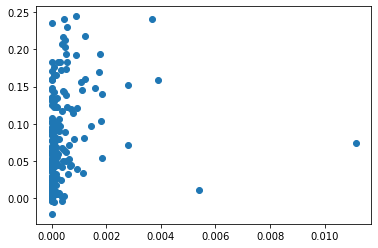

In [478]:
plt.scatter(data["mov_min"], data["TAC_Reading"])

#### Les données semble s'éparpiller un peu plus avec un plus grand degré d'alcolémie

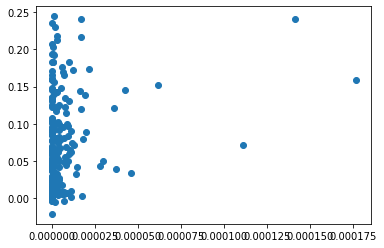

In [475]:
plt.scatter(data["speed_min"], data["TAC_Reading"])

#### Aucune conclusion ne peut être tiré à vue d'oeil sur ce graphique

## Séparation de la Base de données en test et train

In [472]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2) #Séparation 80% train, 20% test

In [333]:
y_test.head()

49    0.011030
36    0.096431
23    0.169698
53    0.009171
43    0.003258
Name: TAC_Reading, dtype: float64

#### Nous avons garder les résultats pour un modèle de régréssion (y_train et y_test) car ce sont des valeurs continues, en effet l'état débriété est fixé arbitrairement au seuil 0.08. Nous avons tout de même aussi utiliser une classification avec l'état d'ébriété comme l'ont fait les chercheurs afin de tester 2 modèles

In [342]:
y_train2 = y_train.copy()
y_train2 = y_train2 > 0.08

y_test2 = y_test.copy()
y_test2 = y_test2 > 0.08

## Modèle 1 :  Régression linéaire simple

In [287]:
from sklearn.linear_model import LinearRegression

In [468]:
regressor = LinearRegression(normalize = True, fit_intercept = True)
regressor.fit(X_train, y_train)

LinearRegression(normalize=True)

#### L'ordonnée à l'origine est calculée, ce n'est pas un modèle linéaire, lorsqu'on est entièrement sobre, on bouge tout de même
#### Les données sont normalisées

In [469]:
y_pred = regressor.predict(X_test)

In [470]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.05088195792450543
Mean Squared Error: 0.003202462575348558
Root Mean Squared Error: 0.05659030460554668


#### Les résultats ne sont pas très prometteurs. Même si les résultats sont moyens, nous n'avons pas assez de valeurs pour obtenir une conclusion si oui ou non cela pourrait servir

{'whiskers': [<matplotlib.lines.Line2D at 0x27a85567d00>,
 'caps': [<matplotlib.lines.Line2D at 0x27a85573400>,
 'boxes': [<matplotlib.lines.Line2D at 0x27a855679a0>],
 'medians': [<matplotlib.lines.Line2D at 0x27a85573a60>],
 'fliers': [<matplotlib.lines.Line2D at 0x27a85573dc0>],
 'means': []}

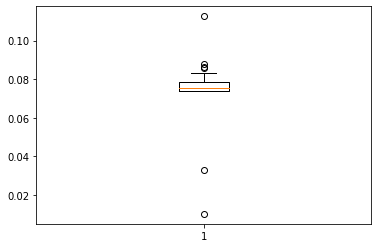

In [471]:
plt.boxplot(y_pred)

#### En plongeant plus dans les détails, nous observons un boxplot centré autour de même valeurs et de très prêt, le modèle est donc complètement mauvais car celui-ci ne peut pas faire une prédiction de quelqu'un de complètement sobre ou très saoul. Après, la base de données montre elle aussi pas une aussi grosse variété dans les résultats mais elle reste tout de même plus variée que le modèle

## Modèle 2 : Gradient Boosting Classifier

In [320]:
from sklearn.ensemble import GradientBoostingClassifier

In [465]:
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1).fit(X_train, y_train2)
clf_gbc.score(X_test, y_test2)

0.8

#### Les hyperparamètres semblent être dans un bon état. 
#### Pour la profondeur, on ne peut pas s'aventurer loin car vu la faiblesse de la base de données en terme de nombre mais aussi en terme de différentes valeurs, on ne peut obtenir une meilleure conculsion. 
#### Pour ce qui est du learning rate, le faire plus baisser, nous obtenons pas une convergence assez rapide et une convergence trop rapide ne peut se faire corriger sur une petite base de données.

In [356]:
y_pred = clf_gbc.predict(X_test)

In [357]:
confusion_matrix(y_test2, y_pred)

array([[28,  5],
       [ 4,  8]], dtype=int64)

#### La matrice de confusion semble être assez bien (pour le nombre de valeurs) mais elle montre bien qu'il n'y a pas assez de valeurs négatives.

## Modèle 3 : Decision Tree Classifier

In [ ]:
from sklearn import tree

In [390]:
clf_tree = tree.DecisionTreeClassifier(max_depth = 3)
clf_tree = clf_tree.fit(X_train, y_train2)

#### La profondeur semble être dans un bon état, une profondeur plus faible ne laisserai pas assez de critères pour décider le retour/résultat, une profondeur plus forte demanderai d'aller dans trop de critères et sachant que ceux-ci sont assez corrélés, cela donne un résultat trop biaisé et donc de l'overfitting

[Text(141.64615384615385, 190.26, 'X[1] <= 0.023\ngini = 0.483\nsamples = 179\nvalue = [106, 73]'),
 Text(51.50769230769231, 135.9, 'X[6] <= -0.016\ngini = 0.19\nsamples = 47\nvalue = [42, 5]'),
 Text(25.753846153846155, 81.53999999999999, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(77.26153846153846, 81.53999999999999, 'X[5] <= 0.13\ngini = 0.124\nsamples = 45\nvalue = [42, 3]'),
 Text(51.50769230769231, 27.180000000000007, 'gini = 0.0\nsamples = 35\nvalue = [35, 0]'),
 Text(103.01538461538462, 27.180000000000007, 'gini = 0.42\nsamples = 10\nvalue = [7, 3]'),
 Text(231.7846153846154, 135.9, 'X[1] <= 0.889\ngini = 0.5\nsamples = 132\nvalue = [64, 68]'),
 Text(180.27692307692308, 81.53999999999999, 'X[7] <= 0.0\ngini = 0.489\nsamples = 113\nvalue = [48, 65]'),
 Text(154.52307692307693, 27.180000000000007, 'gini = 0.497\nsamples = 74\nvalue = [40, 34]'),
 Text(206.03076923076924, 27.180000000000007, 'gini = 0.326\nsamples = 39\nvalue = [8, 31]'),
 Text(283.2923076923077, 81.5399999

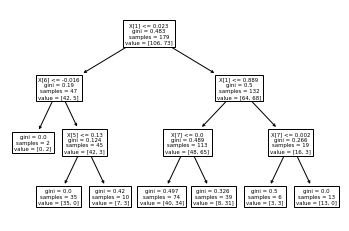

In [351]:
tree.plot_tree(clf_tree)

#### Si je devais faire une conclusion, c'est que le modèle regarde en premier si la personne a fait beaucoup de mouvement (est-ce qu'elle a pu rester calme ou non), si c'est le cas, on va vérifier si les mouvements sont brusques (accélération). Autrement, s'il n'y a pas beaucoup de mouvements, on observe si ceux-ci sont rapides ou non. 
#### Malheureusement, cette conclusion ne peut être forcément bonne au vu du faible nombres d'informations dans la base de données

In [391]:
y_pred = clf_tree.predict(X_test)
confusion_matrix(y_test2, y_pred)

array([[29,  4],
       [ 9,  3]], dtype=int64)

#### On observe un moins bon résultat que le précédent. La répartition entre prédiction "saoul" et "sobre" semble être respectée

## Exportation du modèle en pickle de Gradient Boosting Classifier

In [364]:
import pickle

In [360]:
pickle.dump(clf_gbc, open('model.pickle', 'wb'))